### Import packages

In [14]:
from datetime import datetime
import dateutil.parser
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# The command below means that the output of multiple commands in a cell will be output at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

# Show figures in notebook
%matplotlib inline

sns.set_palette('hls')

### Create dataframe with basic exploration

In [3]:
path = 'data/'
filename = 'loans.csv'

try:
    df = pd.read_csv(path+filename)
except FileNotFoundError:
    # If data is not found, download it from GitHub
    import os
    os.system(f'git clone --single-branch --depth=1 https://github.com/DeltaAnalytics/machine_learning_for_good_data {path}')

df.sample(n=2)
print(f'There are {df.shape[0]} observations and {df.shape[1]} features')

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description,use
601,1564730,550,6,fundraising,NaN,150,15,CM,Food,"Mireille is a 41 year old woman, engaged, moth...",to buy cutlery and food items.
3161,1544609,850,8,expired,NaN,275,18,MZ,Services,"André is 42 years old, married, and the father...",to make car repairs.


There are 6019 observations and 11 features


#### Data Types

In [18]:
df.columns.tolist()
df.dtypes
df.describe()
df[df.dtypes[df.dtypes == 'object'].index].describe()

['id_number',
 'loan_amount',
 'lender_count',
 'status',
 'funded_date',
 'funded_amount',
 'repayment_term',
 'location_country_code',
 'sector',
 'description',
 'use']

id_number                 int64
loan_amount               int64
lender_count              int64
status                   object
funded_date              object
funded_amount             int64
repayment_term            int64
location_country_code    object
sector                   object
description              object
use                      object
dtype: object

,id_number,loan_amount,lender_count,funded_amount,repayment_term
count,6.019000e+03,6019.000000,6019.000000,6019.000000,6019.000000
mean,1.359770e+06,1499.011464,35.661406,1325.070610,11.803290
std,3.719316e+05,2512.517280,73.420256,2444.726815,9.114948
min,1.377200e+04,50.000000,0.000000,0.000000,3.000000
25%,1.425188e+06,300.000000,7.000000,200.000000,8.000000
50%,1.550673e+06,625.000000,16.000000,525.000000,10.000000
75%,1.566204e+06,1825.000000,41.000000,1525.000000,14.000000
max,1.573593e+06,80000.000000,2665.000000,80000.000000,133.000000


,status,funded_date,location_country_code,sector,description,use
count,6019,5082,6002,6019,5677,5677
unique,3,4453,30,14,5277,4325
top,funded,2018-07-22T15:54:41Z,CD,Food,"Florida is a client of IMF Hekima, a saleswoma...",to pay for a stove.
freq,5082,9,400,1738,2,80


#### Missing Values

In [13]:
def num_missing(x):
    return sum(x.isnull())

print('Missing values per column:')
print(df.apply(num_missing,axis=0).where(lambda x : x != 0).dropna())

Missing values per column:
funded_date              937.0
location_country_code     17.0
description              342.0
use                      342.0
dtype: float64


#### Sanity Checks

- is the range of values what you would expect. For example, are all loan_amounts above 0.
- do you have the number of rows you would expect
- is your data for the date range you would expect. For example, is there a strange year in the data like 1880.
- are there unexpected spikes when you plot the data over time

In [18]:
#specific column analysis for numerical types
print(len(df['lender_count']))
print(max(df['funded_amount']))
print(df['loan_amount'].mean())

6019
80000
1499.0114636982887


In [12]:
#specific column analysis for categorical types
df['status'].value_counts()

funded         5082
fundraising     841
expired          96
Name: status, dtype: int64

In [22]:
df[['loan_amount','funded_amount']].tail()

,loan_amount,funded_amount
6014,200,200
6015,200,200
6016,200,200
6017,200,200
6018,200,200


In [4]:
# get rows 1 through 3 and columns 0 through 5
df.iloc[1:3,:5]

,id_number,loan_amount,lender_count,status,funded_date
1,743090,975,34,funded,2014-08-18T09:10:54Z
2,743120,950,25,funded,2014-08-09T17:46:35Z


In [5]:
# get rows with index values of 2-4 and the columns status and lender_count
df.loc[2:4,["status","lender_count"]]

,status,lender_count
2,funded,25
3,funded,28
4,funded,21


In [7]:
df.iloc[:,:]

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description,use
0,736066,4825,60,funded,2014-08-03T17:51:50Z,4825,8,BJ,Retail,NaN,NaN
1,743090,975,34,funded,2014-08-18T09:10:54Z,975,12,BJ,Food,NaN,NaN
2,743120,950,25,funded,2014-08-09T17:46:35Z,950,14,BJ,Services,NaN,NaN
3,743121,825,28,funded,2014-08-24T17:00:38Z,825,14,BJ,Retail,NaN,NaN
4,743124,725,21,funded,2014-08-25T03:24:54Z,725,13,BJ,Retail,NaN,NaN
5,743125,725,27,funded,2014-08-18T23:08:00Z,725,13,BJ,Retail,NaN,NaN
6,743130,725,27,funded,2014-08-19T12:14:49Z,725,13,BJ,Retail,NaN,NaN
7,743134,525,14,funded,2014-07-28T06:20:44Z,525,13,BJ,Services,NaN,NaN
8,743207,950,35,funded,2014-08-26T14:24:08Z,950,14,BJ,Retail,NaN,NaN
9,743228,500,10,funded,2014-08-01T01:54:34Z,500,10,BJ,Food,NaN,NaN


In [11]:
df[df['status'] == 'fundraising']

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description,use
210,1567810,950,15,fundraising,NaN,750,8,BF,Retail,The group is made up of 3 members of whom the ...,to buy some suitcases in quantity for resale.
213,1567905,2950,2,fundraising,NaN,50,14,BF,Food,"Fhatimatoun is 35 years old, married and mothe...",to buy sacks of cereals and charcoal to sell.
214,1567938,2600,3,fundraising,NaN,75,14,BF,Food,"Matagara is 48 years old, married, and is the ...",who wants to buy powdered milk and other ingre...
217,1568867,1875,4,fundraising,NaN,100,10,BF,Food,Tewende Group has just finished their first Ki...,to buy sprouted millet for the preparation of ...
218,1568894,2425,26,fundraising,NaN,1125,8,BF,Food,Kiswendsida has just finished its Kiva loan an...,to buy wheat flour and oil for the fried food ...
219,1568898,900,6,fundraising,NaN,175,8,BF,Food,The group named “Eben Ezer” just finished its ...,to pay for rice and condiments for her restaur...
220,1569523,1800,6,fundraising,NaN,175,8,BF,Clothing,The Sidzadba group just completed its [previou...,"to buy a large quantity of ""pagnes"" to resell."
222,1560770,1275,31,fundraising,NaN,800,10,BF,Food,"Zeneba is 52 yeas old, married and the mother ...","to buy 5 bags of rice, 10 packages of spaghett..."
230,1562208,900,19,fundraising,NaN,500,14,BF,Agriculture,Daouda is married and the father of two childr...,To buy a hundred chickens.
231,1562277,900,5,fundraising,NaN,150,14,BF,Clothing,Seni 1er Jumeau is married and father of four ...,to buy 50 handbags and a dozen pairs of shoes.


In [16]:
df[(df['status'] == 'fundraising')|(df['status'] == 'expired')]

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description,use
210,1567810,950,15,fundraising,NaN,750,8,BF,Retail,The group is made up of 3 members of whom the ...,to buy some suitcases in quantity for resale.
213,1567905,2950,2,fundraising,NaN,50,14,BF,Food,"Fhatimatoun is 35 years old, married and mothe...",to buy sacks of cereals and charcoal to sell.
214,1567938,2600,3,fundraising,NaN,75,14,BF,Food,"Matagara is 48 years old, married, and is the ...",who wants to buy powdered milk and other ingre...
217,1568867,1875,4,fundraising,NaN,100,10,BF,Food,Tewende Group has just finished their first Ki...,to buy sprouted millet for the preparation of ...
218,1568894,2425,26,fundraising,NaN,1125,8,BF,Food,Kiswendsida has just finished its Kiva loan an...,to buy wheat flour and oil for the fried food ...
219,1568898,900,6,fundraising,NaN,175,8,BF,Food,The group named “Eben Ezer” just finished its ...,to pay for rice and condiments for her restaur...
220,1569523,1800,6,fundraising,NaN,175,8,BF,Clothing,The Sidzadba group just completed its [previou...,"to buy a large quantity of ""pagnes"" to resell."
222,1560770,1275,31,fundraising,NaN,800,10,BF,Food,"Zeneba is 52 yeas old, married and the mother ...","to buy 5 bags of rice, 10 packages of spaghett..."
230,1562208,900,19,fundraising,NaN,500,14,BF,Agriculture,Daouda is married and the father of two childr...,To buy a hundred chickens.
231,1562277,900,5,fundraising,NaN,150,14,BF,Clothing,Seni 1er Jumeau is married and father of four ...,to buy 50 handbags and a dozen pairs of shoes.


In [17]:
df.groupby(['sector'])['loan_amount'].sum().reset_index()

,sector,loan_amount
0,Agriculture,1518025
1,Arts,65025
2,Clothing,940975
3,Construction,143950
4,Education,215850
5,Food,2973075
6,Health,263575
7,Housing,72800
8,Manufacturing,43200
9,Personal Use,170025


#### Other Resources

[More SQL like joins](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html)

[10 minute introduction to pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)

[Pandas in ipython notebooks](https://nbviewer.jupyter.org/github/jvns/pandas-cookbook/blob/master/cookbook/A%20quick%20tour%20of%20IPython%20Notebook.ipynb)

[Plethora more resources](https://github.com/josephmisiti/awesome-machine-learning#python-data-analysis)

### Exploratory data analysis visualization techniques

#### Scatter Plots

In [4]:
# visualize relationship between two continuous features
numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
for variable in numeric_vars:
    print(variable)

id_number
loan_amount
lender_count
funded_amount
repayment_term


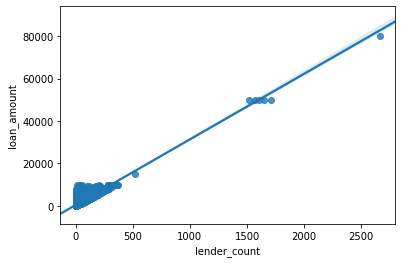

In [5]:
ax = sns.regplot(x='lender_count', y='loan_amount',data=df)

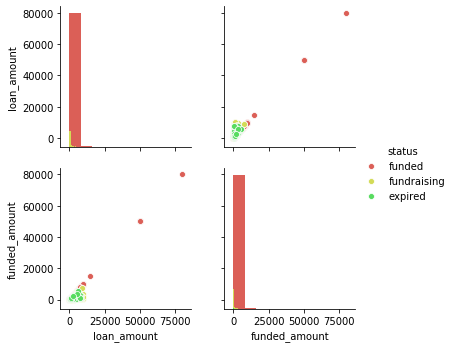

In [29]:
sns.pairplot(df, hue='status', vars=['loan_amount','funded_amount'], dropna=True, diag_kind='hist');

#### Histograms

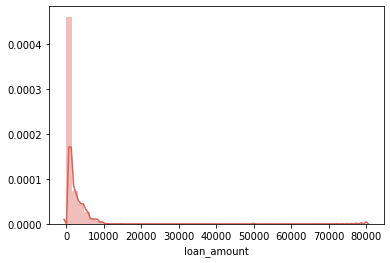

In [30]:
# distribution of values for a single variable
sns.distplot(df['loan_amount'].dropna(axis=0));

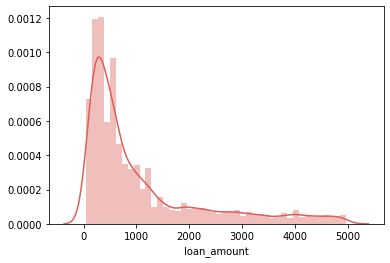

In [33]:
small_loans_df = df[(df['loan_amount']<5000)]
sns.distplot(small_loans_df['loan_amount']);

#### Bar Plot

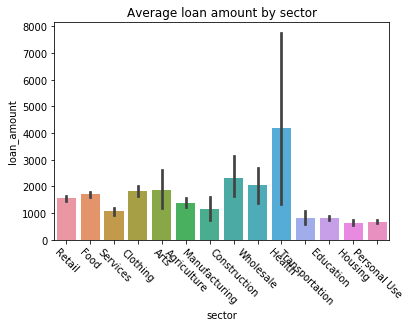

In [36]:
# understanding how categorical groups are different with respect to a continous variable
p = sns.barplot(x='sector', y='loan_amount', data=df, estimator=np.mean);
p.set(title='Average loan amount by sector')
p.set_xticklabels(p.get_xticklabels(),rotation=-45);

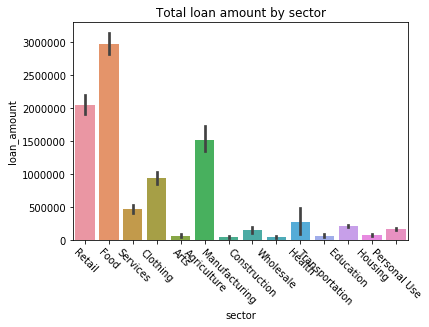

In [37]:
p = sns.barplot(x='sector', y='loan_amount', data=df, estimator=np.sum);
p.set(title='Total loan amount by sector')
p.set_xticklabels(p.get_xticklabels(),rotation=-45);

#### Box Plots

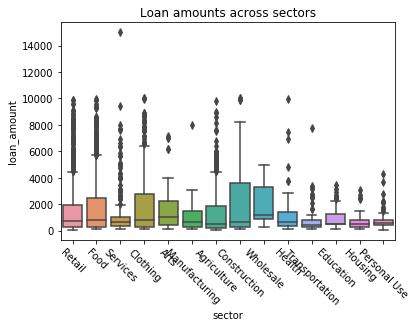

In [43]:
# describes distribution of data based on min, max, median, first & third quartile
p = sns.boxplot(x='sector',
                y='loan_amount',
                data = df[(df['loan_amount']<50000)]);
p.set(title = 'Loan amounts across sectors');
p.set_xticklabels(p.get_xticklabels(),rotation=-45);

#### Time series

/Users/Jenny/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


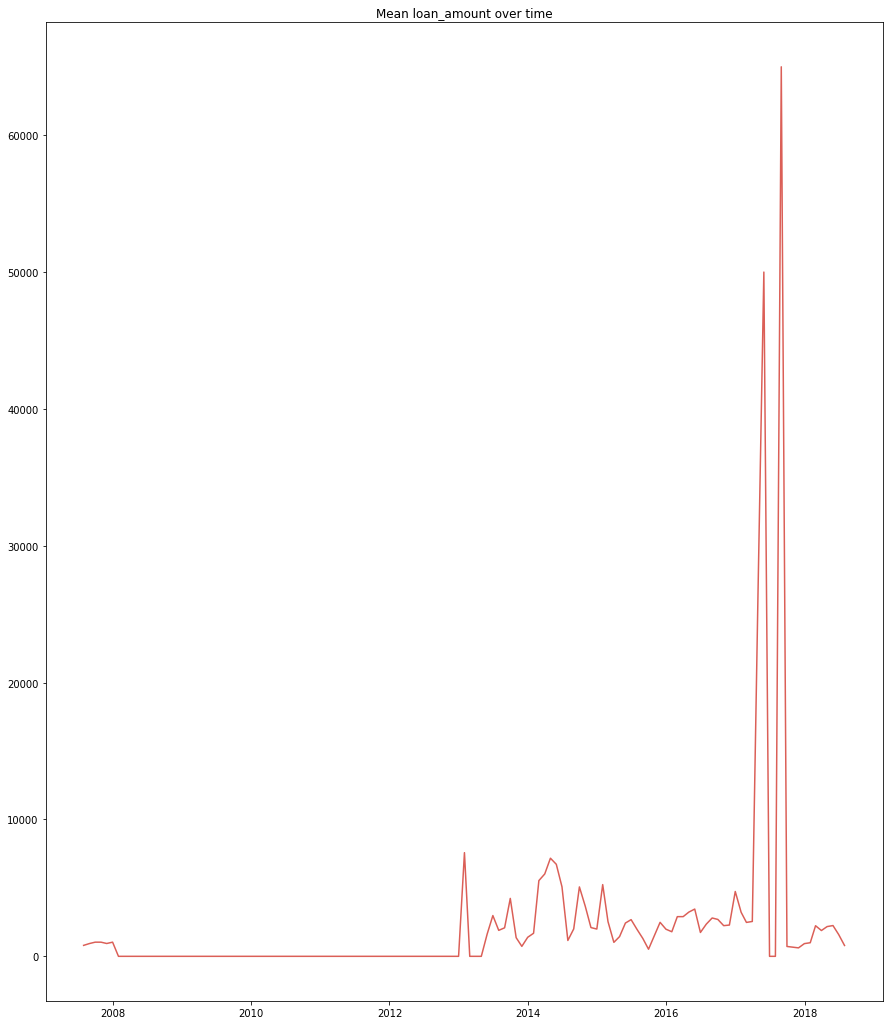

In [45]:
# useful to see how variable changes over time
time_column = 'funded_date'
df[time_column] = pd.to_datetime(df[time_column])

#resample to monthly intervals, taking mean of y variable
time_data = df.resample('M', on=time_column)['loan_amount'].mean().fillna(0)
fig, ax = plt.subplots(figsize=(15,18))
ax.plot(time_data)
plt.title('Mean loan_amount over time');

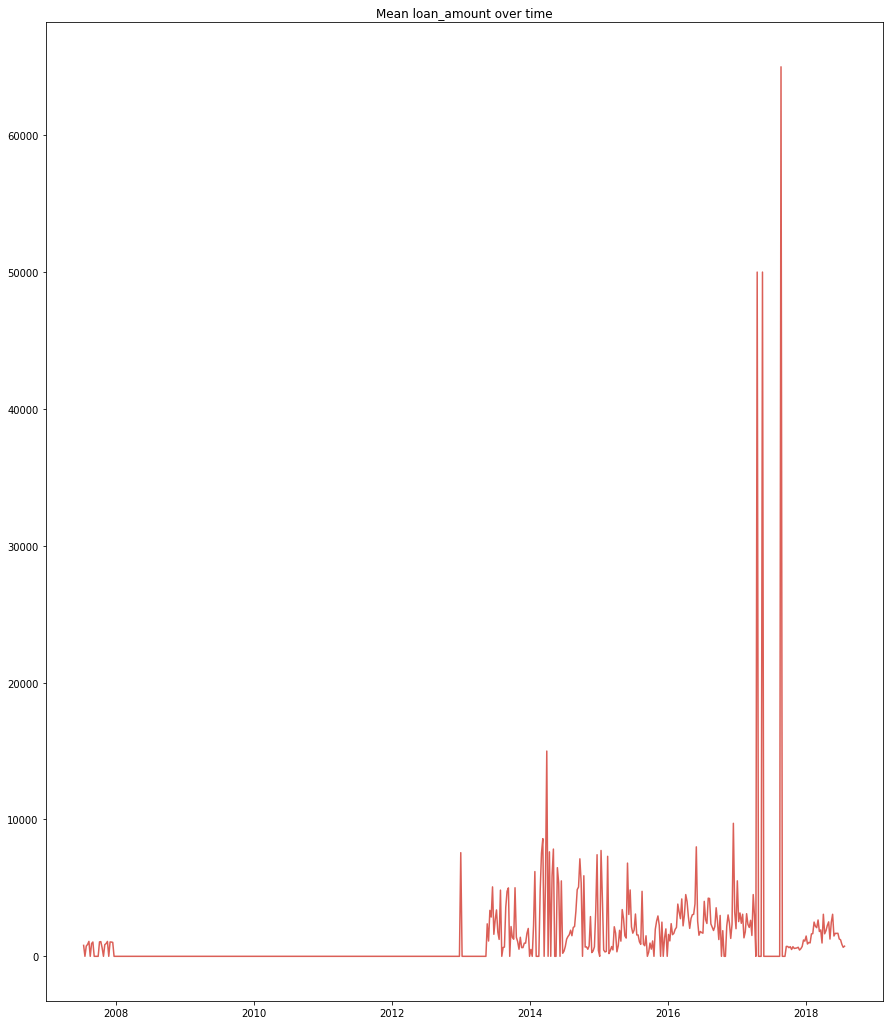

In [46]:
#resample to monthly intervals, taking mean of y variable
time_data = df.resample('7D', on=time_column)['loan_amount'].mean().fillna(0)
fig, ax = plt.subplots(figsize=(15,18))
ax.plot(time_data)
plt.title('Mean loan_amount over time');